### Prepare Data

In [ ]:
from glob import glob
from ConceptMining import ConceptMiner
from settings import settings

import pickle

In [ ]:
batch_size = 70
images = [i for i in glob("../dataset/Images/*.jpg")]
Miner = ConceptMiner(images = images, load_model= True)

# encodings, captions = Miner.get_image_caption(get_encodings = True, batch_size = batch_size)

In [ ]:
# with open('encodings.pkl', 'wb') as f:
#     pickle.dump({'encodings':encodings, 'captions': captions}, f)
with open('encodings.pkl', 'rb') as f:
	data = pickle.load(f)
	encodings = data['encodings']
	captions = data['captions']

In [ ]:
concept_model, generated_concepts = Miner.concept_modeling(encodings = encodings, 
                                                           captions = captions, 
                                                           batch_size = batch_size)

with open("generated_concepts.pkl", "wb") as f:
    pickle.dump(generated_concepts, f)


### Cluser topics by semantic similarity 
- Cluser concepts
- Sample concepts taking as mean the centroid +- a random noice to simulate user externalization

In [8]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from umap import UMAP
import os, pickle
import numpy as np

from transformers import AutoTokenizer, AutoModel

with open("generated_concepts.pkl", "rb") as f:
    generated_concepts = list(set(pickle.load(f)) - {""})
    
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

In [9]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_embedding(sentences, model, tokenizer, batch_size = 16):
    with torch.no_grad():

        output = None
        for i in range(0, len(sentences), batch_size):
            encoded_input = tokenizer(sentences[i: i + batch_size], padding=True, return_tensors='pt')

            model_output = model(**encoded_input)
            sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
            output = sentence_embeddings if output is None else torch.cat([output, sentence_embeddings])

    return output

concepts_embeddings = get_embedding(generated_concepts, model, tokenizer, batch_size = 16)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

similarity_matrix = cosine_similarity(concepts_embeddings)

# Apply Spectral Clustering
num_clusters = 20
spectral = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', random_state=42)
labels = spectral.fit_predict(similarity_matrix)

# Group words by topic
topic_groups = {}
for word, cluster in zip(generated_concepts, labels):
    topic_groups.setdefault(cluster, []).append(word)
    
with open("generated_concepts.pkl", "wb") as f:
	pickle.dump({'concepts':generated_concepts,
              'topic_groups': topic_groups}, f)

#### Preprocess the data for simulation


In [1]:
import pickle
from glob import glob

import random

with open("generated_concepts.pkl", "rb") as f:
	data = pickle.load(f)
	generated_concepts = data['concepts']
	topic_groups = data['topic_groups']

with open('encodings.pkl', 'rb') as f:
	data = pickle.load(f)
	encodings = data['encodings']
	captions = data['captions']

images = [i for i in glob("../dataset/Images/*.jpg")]

In [2]:
concept_instance = {i:[] for i in generated_concepts}

for i, path in enumerate(images):
	for c in captions[i].split():
		if c in generated_concepts:
			concept_instance[c] += [path]

remove_topics = []
for i in topic_groups:
	remove = [j for j in topic_groups[i] if len(concept_instance[j]) < 10]
	for j in remove:
		topic_groups[i].remove(j)
	print(f"Topic {i}:", len(topic_groups[i]))
	if len(topic_groups[i]) < 8:
		remove_topics.append(i)

for i in remove_topics:
	del topic_groups[i]

Topic 3: 16
Topic 1: 28
Topic 0: 12
Topic 11: 24
Topic 13: 14
Topic 2: 7
Topic 9: 8
Topic 5: 20
Topic 4: 13
Topic 6: 7
Topic 8: 18
Topic 16: 15
Topic 18: 5
Topic 7: 8
Topic 19: 15
Topic 12: 8
Topic 17: 16
Topic 14: 9
Topic 10: 0
Topic 15: 7


Text(0.5, 0, 'Concepts')

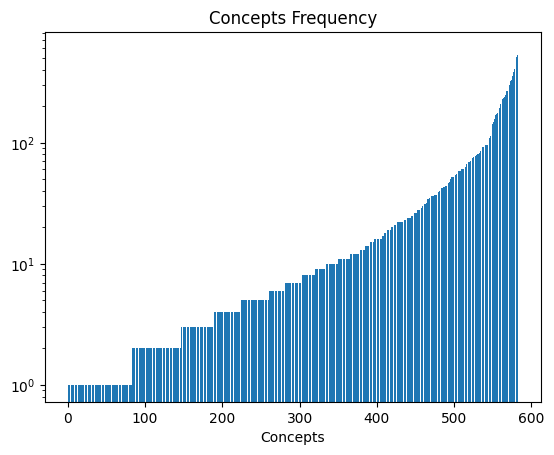

In [3]:
from matplotlib import pyplot as plt	
plt.bar(range(len(generated_concepts)), sorted([len(i) for i in concept_instance.values()]), log = True)
plt.title("Concepts Frequency")
plt.xlabel("Concepts")

Text(0.5, 0, 'Topics')

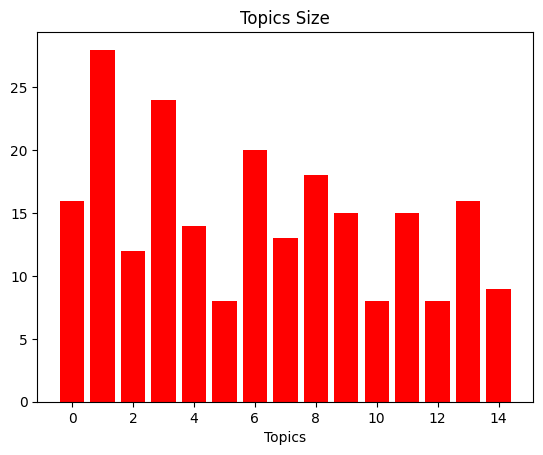

In [4]:
plt.bar(range(len(topic_groups)), [len(topic_groups[i]) for i in topic_groups], color = 'r')
plt.title("Topics Size")
plt.xlabel("Topics")

In [4]:
import random; random.seed(42)
import numpy as np; np.random.seed(42)
import torch; torch.manual_seed(42)	

from einops import rearrange, repeat

import gymnasium as gym
from matplotlib import pyplot as plt


#actor critic model
class Actor(torch.nn.Module):
	
    
	def __init__(self, state_dim: int, action_dim: int,
			  lr_optimizer: float = 0.01):
		super(Actor, self).__init__()

		self.model = torch.nn.Sequential(
			torch.nn.Linear(state_dim, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, action_dim),
		)

		self.max_step = None

		self.criterion = torch.nn.MSELoss()
		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
		self.model.to(self.device)

		self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr_optimizer)
		
	def forward(self, state):
		return self.model(state.to(self.device))
		# return self.model(torch.cat([state, action], dim = -1).to(self.device)).squeeze(-1)
	
	def save(self, path):
		torch.save(self.state_dict(), path)

	def load(self, path):
		self.load_state_dict(torch.load(path, map_location=self.device))
    
	

class Critic(torch.nn.Module):

	def __init__(self, state_dim: int,
			  lr_optimizer: float = 0.01):
		super(Critic, self).__init__()
		
		self.model = torch.nn.Sequential(
			torch.nn.Linear(state_dim, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 1),
		)

		self.criterion = torch.nn.MSELoss()
		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
		self.model.to(self.device)

		self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr_optimizer)
		

	def forward(self, state):
		return self.model(state.to(self.device))

	def save(self, path):
		torch.save(self.state_dict(), path)



def update_actor_critic(buffer, gamma, actions_encode):

	rewards = torch.tensor([x['reward'] for x in buffer]).to(device=Pi.device).reshape(-1, 1)
	state = torch.cat([x['state'] for x in buffer]).to(device=Pi.device)
	next_state = torch.cat([x['next_state'] for x in buffer]).to(device=Pi.device)
	action = torch.stack([x['action'] for x in buffer]).to(device=Pi.device).reshape(-1, 1)
	dones = torch.tensor([float(x['end_state']) for x in buffer]).to(device=Pi.device).reshape(-1, 1)


	values = V(state)
	next_values = V(next_state).detach()

	loss_critic = V.criterion(rewards + gamma*next_values*(1 - dones), values)

	qa = get_pi_a_s(state, actions_encode)
	
	log_probs = torch.log(qa.gather(1, action))
	advantage = (rewards + gamma * next_values * (1 - dones) - values).detach()

	loss_actor = -torch.mean(log_probs * advantage)

	Pi.optimizer.zero_grad()
	V.optimizer.zero_grad()

	loss_critic.backward()
	loss_actor.backward()

	Pi.optimizer.step()
	V.optimizer.step()

	return loss_critic.item(), loss_actor.item()


def encode_actions(action, n_actions):

	if not isinstance(action, torch.Tensor):
		action = torch.tensor(action)
	return torch.nn.functional.one_hot(action, num_classes=n_actions).float()

def get_pi_a_s(state, actions_encode):
	
	action_latent = Pi.forward(state) #b x action_dim
	preferences = action_latent @ actions_encode.T

	action_probs = torch.nn.functional.softmax(preferences - preferences.max(dim=-1, keepdim=True)[0], dim = -1) + 1e-8
	return action_probs

def preprocess_state(state):
	return torch.tensor(state).float().reshape(1, -1)

episodes = 400
episode_length = 1000
dataset_coverage_step = .75
gamma = 0.99
buffer = []
actions_embedd_dim = 2
buffer_size = 512
lr_optimizer = 1e-4

# env = gym.make('MountainCar-v0')
env = gym.make('CartPole-v1')

Pi = Actor(state_dim = env.observation_space.shape[0], action_dim = actions_embedd_dim, lr_optimizer = lr_optimizer)
V = Critic(state_dim = env.observation_space.shape[0], lr_optimizer = lr_optimizer)

#---
from tqdm import tqdm

actions_encode = encode_actions([i  for i in range(env.action_space.n)], env.action_space.n).to(Pi.device)
history = {'rewards': [],
		    'loss_critic': [], 
			'loss_actor': []}

for i in range(episodes):

	prev_state, _ = env.reset()
	prev_state = preprocess_state(prev_state)

	itera = tqdm(range(episode_length), desc = f"Episode {i}")

	for iteration in itera:

		preferences = get_pi_a_s(prev_state, actions_encode)		
		action = torch.multinomial(preferences, 1).squeeze(-1)
		
		state, reward, done, _, _ = env.step(action.item())
		reward = reward if not done else -0.1  

		state = preprocess_state(state)

		buffer.append({'state': prev_state,
						'action': action.detach(), 
						'reward': reward, 
						'next_state': state, 
						'end_state': done})
		
		history['rewards'].append(reward)
		if len(buffer) >= buffer_size:
			loss_critic, loss_actor = update_actor_critic(buffer, gamma, actions_encode)
			history['loss_critic'].append(loss_critic)
			history['loss_actor'].append(loss_actor)
			buffer = buffer[-buffer_size + 1:]

		prev_state = state

		itera.set_postfix({'Reward': sum(history['rewards'][-iteration:]),
						'Loss Critic': sum(history['loss_critic'][-iteration:]),
						'Loss Actor': sum(history['loss_actor'][-iteration:])} )
		if done:
			# print(reward, done, state)
			break
		
	if Pi.max_step is None or Pi.max_step < iteration:
		Pi.max_step = iteration
		Pi.save(f"actor.pt")
		V.save(f"critic.pt")

env.close()


Episode 297:   5%|▌         | 53/1000 [00:00<00:04, 194.07it/s, Reward=52, Loss Critic=0.0116, Loss Actor=-0.00195] 


KeyboardInterrupt: 

Text(0.5, 0, 'Iterations')

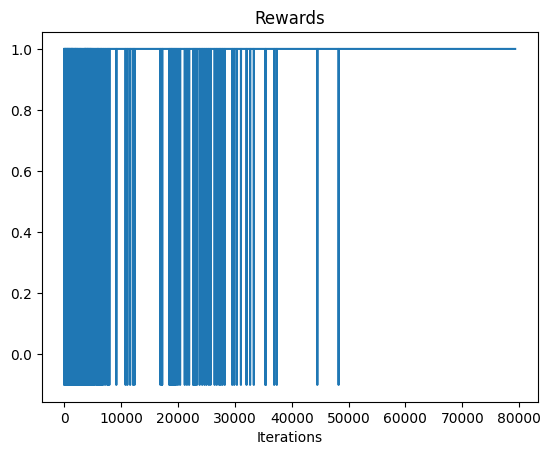

In [5]:
plt.plot(history['rewards'])
plt.title("Rewards")
plt.xlabel("Iterations")

In [3]:
Pi.forward(prev_state.repeat(len(actions_encode), 1), 
												actions_encode).argmax()

tensor(0, device='cuda:0')

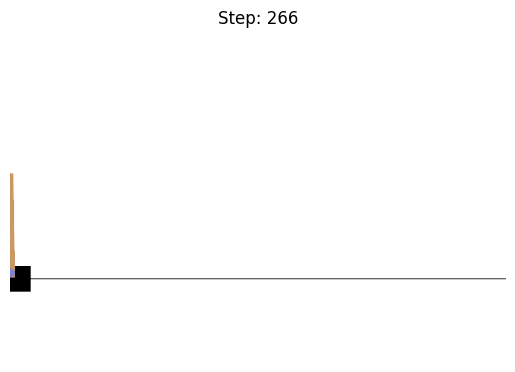

[-2.400093   -0.5861118  -0.00980574  0.14581966]


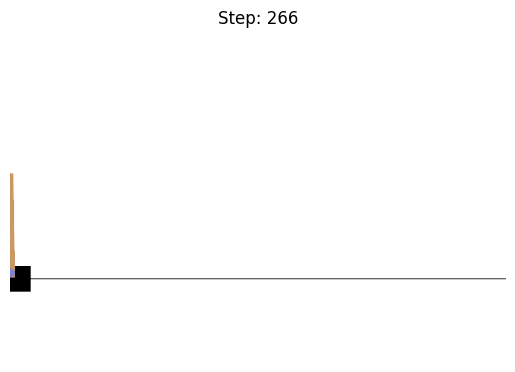

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

def show_state(env, step=0):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.title(f"Step: {step}")
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

Pi.load('actor.pt')
env = gym.make('CartPole-v1', render_mode='rgb_array')
prev_state, info = env.reset()
prev_state = preprocess_state(prev_state)

for step in range(int(1e4)):
	preferences =  get_pi_a_s(prev_state, actions_encode)

	action = preferences.argmax()

	observation, reward, terminated, _, _ = env.step(action.item())
	print(action)

	prev_state = preprocess_state(observation)
	prev_action = action

	show_state(env, step=step)

	if terminated:
		print(observation)
		break

env.close()
